# Generación de piezas musicales con CNN

In [ ]:
!pip install pypianoroll

In [285]:
import os
import numpy as np
#from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.keras.backend as K 
import tensorflow.keras as keras
from tensorflow.keras.utils import plot_model
#import tensorflow as tf
#import gc
#import pickle
from sklearn.model_selection import train_test_split
import pypianoroll as pr
import matplotlib.pyplot as plt

In [151]:
ENV = 'local'
if(ENV == 'colab'):
    BASE_PATH = '/content/drive/MyDrive/uni/TFG2023/generative-music/'
    from google.colab import drive
    drive.mount('/content/drive')
    
elif(ENV == 'local'):
    BASE_PATH = './'
else:
    raise Exception()

In [153]:
DATASET = 'sample'
DATA_PATH=os.path.join(BASE_PATH, 'data')
DATASET_PATH = os.path.join(DATA_PATH, DATASET)

STORE_PATH=os.path.join(BASE_PATH,'generated')

RANDOM_SEED=616
SEQ_LEN=32

In [210]:
# CNNDatasetEncoder
class CNNDatasetEncoder:
    
    def __init__(self, path, seq_len=32, delimiter='/', blend_tracks=False):
        self.path = path
        self.parsed_files = self.load()
        self.seq_len = seq_len
        self.delimiter = delimiter
        self.blend_tracks = blend_tracks
    
    def load(self):
        
        # Get song data from data_path and parse it as a pypianoroll object
        songs = {}

        for path,subdir,files in os.walk(self.path):
            for file in files:
                if (file[-3:] == 'mid'):
                    try:
                        song = pr.read(os.path.join(path,file))
                        songs[file[:-4]] = song
                    except:
                        print(f'Parsing file {file} failed. Skipping.')
                        continue
        return songs
        
    def encode(self):
        encoded_files = {}
        titles, files = list(self.parsed_files.keys()), list(self.parsed_files.values())
        
        
        for i,file in enumerate(files):
            print(f'Processing song {titles[i]}')

            # Clean short songs
            if(file.get_max_length() < self.seq_len):
                print(f'Skipping song {titles[i]}')
                continue

            encoded_file = self.encode_song(file)
            encoded_files[titles[i]] = encoded_file
        
        self.encoded_files = encoded_files
    
    def encode_song(self, song):
        
        processed_tracks = {}
        
        padded = song.pad_to_same()
        
        if(self.blend_tracks):
            return { 'MAIN_TRACK':padded.binarize().blend().astype(float) }
        
        for t in song.tracks:
            bt = t.binarize()
            processed_tracks[bt.name] = bt.pianoroll.astype(float)
        return processed_tracks

In [137]:
class CNNSequenceGenerator:
    def __init__(self, encoder, seq_len=SEQ_LEN):
        self.encoded_files = encoder.encoded_files
        self.seq_len = seq_len
        
    def generate_sequences(self, validation_split=0.15):
        inputs = []
        outputs = []
        
        for n, s in self.encoded_files.items():
            pianoroll = s['MAIN_TRACK']

            X_s = [pianoroll[SEQ_LEN*i:SEQ_LEN*i + SEQ_LEN] for i in range(int((pianoroll.shape[0] - SEQ_LEN)/SEQ_LEN))]
            y_s = [pianoroll[SEQ_LEN*i + SEQ_LEN:SEQ_LEN*i + SEQ_LEN*2] for i in range(int((pianoroll.shape[0] - SEQ_LEN)/SEQ_LEN))]

            inputs = inputs + X_s
            outputs = outputs + y_s
        
        X = np.reshape(inputs, (len(inputs), self.seq_len, 128))
        y = np.reshape(outputs, (len(outputs), self.seq_len, 128))
        
        print(f'Input shape: {X.shape}')
        print(f'Output shape: {y.shape}')
        
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=validation_split, random_state=RANDOM_SEED)
        
        return X_train, X_valid, y_train, y_valid


In [279]:
class CNNAutoencoder:
    def __init__(self, enc_num_units, enc_kernels, enc_strides, dec_num_units, dec_kernels, dec_strides, seq_len, lr, latent_dim = 64):
        
        self.name = 'base_conv'
        
        if(not os.path.exists(os.path.join(BASE_PATH, 'weights',self.name))):
            os.mkdir(os.path.join(BASE_PATH, 'weights',self.name))
        
        self.weights_folder = os.path.join(BASE_PATH, 'weights',self.name)
        
        input_shape = (seq_len, 128, 1)
        
        # ENCODER
        i_e = keras.layers.Input(shape=input_shape, name='enc_input')
        
        x = keras.layers.Conv2D(filters=enc_num_units[0], kernel_size=enc_kernels[0], strides=enc_strides[0], padding='same')(i_e)
        #x = keras.layers.BatchNormalization()(x)
        x = keras.layers.ReLU()(x)
        
        x = keras.layers.Conv2D(filters=enc_num_units[1], kernel_size=enc_kernels[1], strides=enc_strides[1], padding='same')(x)
        #x = keras.layers.BatchNormalization()(x)
        x = keras.layers.ReLU()(x)
        
        x = keras.layers.Conv2D(filters=enc_num_units[2], kernel_size=enc_kernels[2], strides=enc_strides[2], padding='same')(x)
        #x = keras.layers.BatchNormalization()(x)
        x = keras.layers.ReLU()(x)
        
        #x = keras.layers.Dropout(0.4)(x)
        
        dec_shape = K.int_shape(x)[1:]
        
        x = keras.layers.Flatten()(x)
        
        e = keras.layers.Dense(latent_dim)(x)
        
        self.encoder = keras.Model(i_e, e, name='cnn_encoder')
        
        
        # DECODER
        i_d = keras.layers.Input(shape=(latent_dim,), name='dec_input')
        
        x = keras.layers.Dense(np.prod(dec_shape))(i_d)
        x = keras.layers.Reshape((dec_shape))(x)
        
        x = keras.layers.Conv2DTranspose(filters=dec_num_units[0], kernel_size=dec_kernels[0], strides=dec_strides[0], padding='same')(x)
        x = keras.layers.ReLU()(x)
        
        x = keras.layers.Conv2DTranspose(filters=dec_num_units[1], kernel_size=dec_kernels[1], strides=dec_strides[1], padding='same')(x)
        x = keras.layers.ReLU()(x)
        
        x = keras.layers.Conv2DTranspose(filters=dec_num_units[2], kernel_size=dec_kernels[2], strides=dec_strides[2], padding='same')(x)
        d = keras.layers.Activation('sigmoid')(x)
        
        self.decoder = keras.Model(i_d, d, name='cnn_decoder')
        
        autoencoder_input = i_e
        autoencoder_output = self.decoder(e)
        
        self.autoencoder = keras.Model(autoencoder_input, autoencoder_output, name='cnn_autoencoder')
        
        # COMPILATION
        opt = keras.optimizers.Adam(learning_rate=lr)
        
        def collapsed_rmse(y_true, y_pred):
            return K.mean(K.square(y_true - y_pred), axis=[1,2])
        
        self.autoencoder.compile(optimizer=opt, loss=collapsed_rmse)
        
        self.get_model_summary()
        
        
    def fit_model(self, train_inputs, train_outputs, validation_inputs, validation_outputs, store_path, epochs=100, batch_size=32):
    
        weights_folder = self.weights_folder

        checkpoint = ModelCheckpoint(
            os.path.join(weights_folder, f"{DATASET}_weights.h5"),
            monitor='loss',
            verbose=0,
            save_best_only=True,
            mode='min'
        )

        early_stopping = EarlyStopping(
            monitor='loss'
            , restore_best_weights=True
            , patience = 10
        )


        callbacks_list = [ checkpoint, early_stopping ]

        history = self.autoencoder.fit(train_inputs, train_outputs
                  , epochs=epochs, batch_size=batch_size
                  , callbacks=callbacks_list
                  , validation_data=(validation_inputs, validation_outputs)
                  , shuffle=True
                 )
        
        self.autoencoder.save(os.path.join(weights_folder, f"{DATASET}_model.h5"))
        
        return history
    
    def get_model_summary(self):
        self.encoder.summary()
        print('--------------------')
        self.decoder.summary()
        print('--------------------')
        self.autoencoder.summary()
        
    def plot_model_graph(self):
        return plot_model(self.model)
    
    def plot_loss(self, history):
        plt.figure()
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train loss', 'Validation loss'])
        plt.show()

In [211]:
encoder = CNNDatasetEncoder('./data/sample/', blend_tracks=True)

In [212]:
encoder.encode()

Processing song aver2
Processing song gen


In [213]:
s=encoder.encoded_files['gen']

In [180]:
seq_generator = CNNSequenceGenerator(encoder)

In [181]:
X_train, X_valid, y_train, y_valid = seq_generator.generate_sequences()

Input shape: (22, 32, 128)
Output shape: (22, 32, 128)


In [280]:
enc_num_units = [32, 64, 128]
enc_kernels = [(4,4), (4,4), (4,4)]
enc_strides = [1,2,1]
dec_num_units = [64, 32, 1]
dec_kernels = [(4,4), (4,4), (4,4)]
dec_strides = [1,2,1]
lr = 0.001

cnn = CNNAutoencoder(enc_num_units, enc_kernels, enc_strides, dec_num_units, dec_kernels, dec_strides, SEQ_LEN, lr)

Model: "cnn_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 enc_input (InputLayer)      [(None, 32, 128, 1)]      0         
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 128, 32)       544       
                                                                 
 re_lu_40 (ReLU)             (None, 32, 128, 32)       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 16, 64, 64)        32832     
                                                                 
 re_lu_41 (ReLU)             (None, 16, 64, 64)        0         
                                                                 
 conv2d_27 (Conv2D)          (None, 16, 64, 128)       131200    
                                                                 
 re_lu_42 (ReLU)             (None, 16, 64, 128)       

In [287]:
train_hist=cnn.fit_model(X_train, y_train, X_valid, y_valid, STORE_PATH, epochs=10)

Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 96.1638 - val_loss: 32.1950
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 95.9169 - val_loss: 32.0697
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 95.8076 - val_loss: 32.0396
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 95.7775 - val_loss: 32.0279
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 95.7638 - val_loss: 32.0159
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 95.7541 - val_loss: 32.0084
Epoch 7/10
1/1 [==============================] - 0s 466ms/step - loss: 95.7619 - val_loss: 32.0157
Epoch 8/10
1/1 [==============================] - 0s 456ms/step - loss: 95.7671 - val_loss: 32.0054
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 95.7539 - val_loss: 32.0054
Epoch 10/10
1/1 [==============================] - 1s 953ms/step - loss: 95.7539 - val_loss: 32.0052


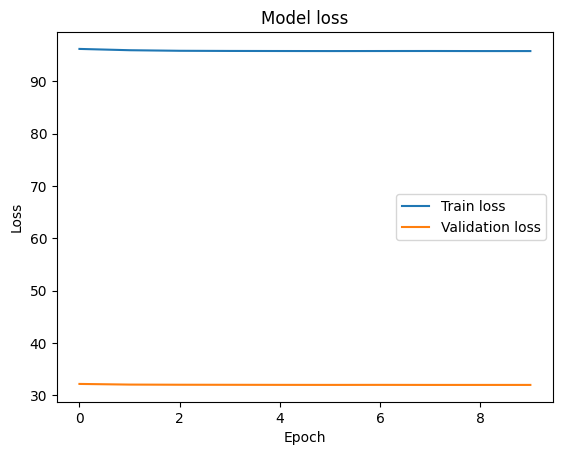

In [288]:
cnn.plot_loss(train_hist)

In [275]:
class CNNSampleGenerator:
    def __init__(self, model, encoder, store_path=STORE_PATH):
        self.model = model.autoencoder
        self.encoder = encoder
        self.n_sample = 0
        self.store_path = store_path
    
    def generate(self, seed, sample_length, threshold=0.6):
        seed = seed.astype(float)
        stream = seed
        
        for _ in range(sample_length):
            
            # add dimension for batch
            # (1, max_seq_len, vocab_size)
            # network_input = [np.reshape(notes_seed,(1,64)),np.reshape(durations_seed,(1,self.seq_len))]
            p_in = np.reshape(seed, (1,self.encoder.seq_len, 128))
            
            
            # make a prediction
            p_out = self.model.predict(p_in,verbose=0)
            p_out[p_out < threshold] = 0.0
            p_out[p_out >= threshold] = 1.0
            
            # update seed
            p_out = np.reshape(p_out, (self.encoder.seq_len,128))
            print(stream.shape, p_out.shape)
            stream = np.concatenate((stream, p_out))
            
        self.generated_sequence = stream
        self.n_sample=self.n_sample+1
        print(f'Generated sample n.{self.n_sample}')
        
        
    def gen2midi(self):

        filename = f'{DATASET}-{self.model.name}_n_{self.n_sample}.mid'

        pianoroll = self.generated_sequence

        bt = pr.BinaryTrack(name='track1', pianoroll=pianoroll)
        print(bt.pianoroll)
        multitrack = pr.Multitrack(name='song1',tracks=[bt])
        
        self.plot_sample(multitrack)

        pr.write(f'{self.store_path}/{filename}', multitrack)
        print(f'Saved with name {filename}.')
        
    def plot_sample(self, midi):
        midi.plot()

In [214]:
pianoroll = s['MAIN_TRACK']

In [221]:
s_in=pianoroll[0:32,:]

In [289]:
sampler = CNNSampleGenerator(cnn, encoder)

In [292]:
sampler.generate(s_in, sample_length=20)

(32, 128) (32, 128)
(64, 128) (32, 128)
(96, 128) (32, 128)
(128, 128) (32, 128)
(160, 128) (32, 128)
(192, 128) (32, 128)
(224, 128) (32, 128)
(256, 128) (32, 128)
(288, 128) (32, 128)
(320, 128) (32, 128)
(352, 128) (32, 128)
(384, 128) (32, 128)
(416, 128) (32, 128)
(448, 128) (32, 128)
(480, 128) (32, 128)
(512, 128) (32, 128)
(544, 128) (32, 128)
(576, 128) (32, 128)
(608, 128) (32, 128)
(640, 128) (32, 128)
Generated sample n.2


[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
Saved with name sample-cnn_autoencoder_n_2.mid.


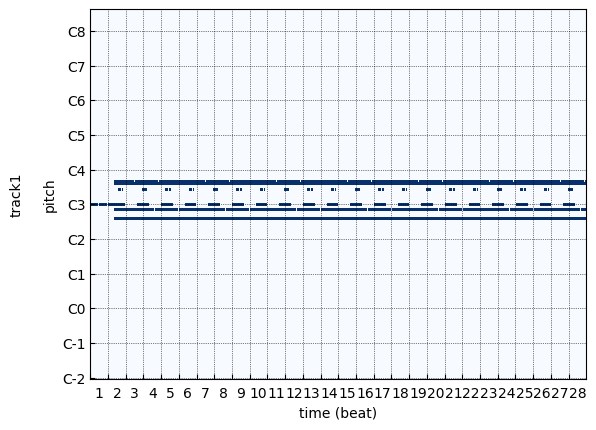

In [293]:
sampler.gen2midi()

In [294]:
sampler.generated_sequence

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [91]:
pianoroll[SEQ_LEN:SEQ_LEN*2,:]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [122]:
pianoroll.shape

(384, 128)

In [123]:
for i in range(int((pianoroll.shape[0] - SEQ_LEN)/SEQ_LEN)):
    print(f'from {SEQ_LEN*i} to {SEQ_LEN*i + SEQ_LEN} for X')
    print(f'from {SEQ_LEN*i + SEQ_LEN} to {SEQ_LEN*i + SEQ_LEN*2} for y')

from 0 to 32 for X
from 32 to 64 for y
from 32 to 64 for X
from 64 to 96 for y
from 64 to 96 for X
from 96 to 128 for y
from 96 to 128 for X
from 128 to 160 for y
from 128 to 160 for X
from 160 to 192 for y
from 160 to 192 for X
from 192 to 224 for y
from 192 to 224 for X
from 224 to 256 for y
from 224 to 256 for X
from 256 to 288 for y
from 256 to 288 for X
from 288 to 320 for y
from 288 to 320 for X
from 320 to 352 for y
from 320 to 352 for X
from 352 to 384 for y


In [103]:
X = [pianoroll[SEQ_LEN*i:SEQ_LEN*i + SEQ_LEN] for i in range(int((pianoroll.shape[0] - SEQ_LEN)/SEQ_LEN))]
y = [pianoroll[SEQ_LEN*i + SEQ_LEN:SEQ_LEN*i + SEQ_LEN*2] for i in range(int((pianoroll.shape[0] - SEQ_LEN)/SEQ_LEN))]

In [106]:
for yy in y:
    print(yy.shape)

(32, 128)
(32, 128)
(32, 128)
(32, 128)
(32, 128)
(32, 128)
(32, 128)
(32, 128)
(32, 128)
(32, 128)
(32, 128)


In [114]:
X = []
y = []
for n, s in encoder.encoded_files.items():
    pianoroll = s['MAIN_TRACK']
    
    X_s = [pianoroll[SEQ_LEN*i:SEQ_LEN*i + SEQ_LEN] for i in range(int((pianoroll.shape[0] - SEQ_LEN)/SEQ_LEN))]
    y_s = [pianoroll[SEQ_LEN*i + SEQ_LEN:SEQ_LEN*i + SEQ_LEN*2] for i in range(int((pianoroll.shape[0] - SEQ_LEN)/SEQ_LEN))]
    
    X = X + X_s
    y = y + y_s

In [196]:
seed = X[0]

In [133]:
X=np.reshape(X,(len(X),SEQ_LEN, 128))
y=np.reshape(y,(len(y),SEQ_LEN, 128))

In [134]:
X.shape, y.shape

((22, 32, 128), (22, 32, 128))